In [64]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from mlfinlab.multi_product.etf_trick import get_futures_roll_series
# Load data
url = "https://raw.githubusercontent.com/hudson-and-thames/example-data/main/futures_stitched.csv"
aggregated_df = pd.read_csv(url, index_col=0, parse_dates=[0])  
len(aggregated_df)

450

In [65]:
aggregated_df.columns

Index(['close', 'open', 'high', 'low', 'volume', 'ticker', 'nearest_contract'], dtype='object')

In [66]:
# Get roll gaps (absolute and relative)
roll_gaps_absolute = get_futures_roll_series(aggregated_df,
                                             open_col="open",
                                             close_col="close",
                                             sec_col="ticker",
                                             current_sec_col="nearest_contract",
                                             method="absolute",)
roll_gaps_absolute

date
2021-01-04      0.00
2021-01-05      0.00
2021-01-06      0.00
2021-01-07      0.00
2021-01-08      0.00
               ...  
2022-09-23   -184.08
2022-09-26   -184.08
2022-09-27   -184.08
2022-09-28   -184.08
2022-09-29   -184.08
Name: close, Length: 450, dtype: float64

In [67]:
roll_gaps_relative = get_futures_roll_series(aggregated_df,
                                             open_col="open",
                                             close_col="close",
                                             sec_col="ticker",
                                             current_sec_col="nearest_contract",
                                             method="relative",)

roll_gaps_relative

date
2021-01-04    1.000000
2021-01-05    1.000000
2021-01-06    1.000000
2021-01-07    1.000000
2021-01-08    1.000000
                ...   
2022-09-23    0.779729
2022-09-26    0.779729
2022-09-27    0.779729
2022-09-28    0.779729
2022-09-29    0.779729
Name: close, Length: 450, dtype: float64

In [68]:
# Filter out rows with price info of the nearest contract only
# This forms the basis of the continuous contract
continuous_contract = aggregated_df[aggregated_df.ticker == aggregated_df.nearest_contract]

len(continuous_contract)

450

In [69]:
continuous_contract.columns

Index(['close', 'open', 'high', 'low', 'volume', 'ticker', 'nearest_contract'], dtype='object')

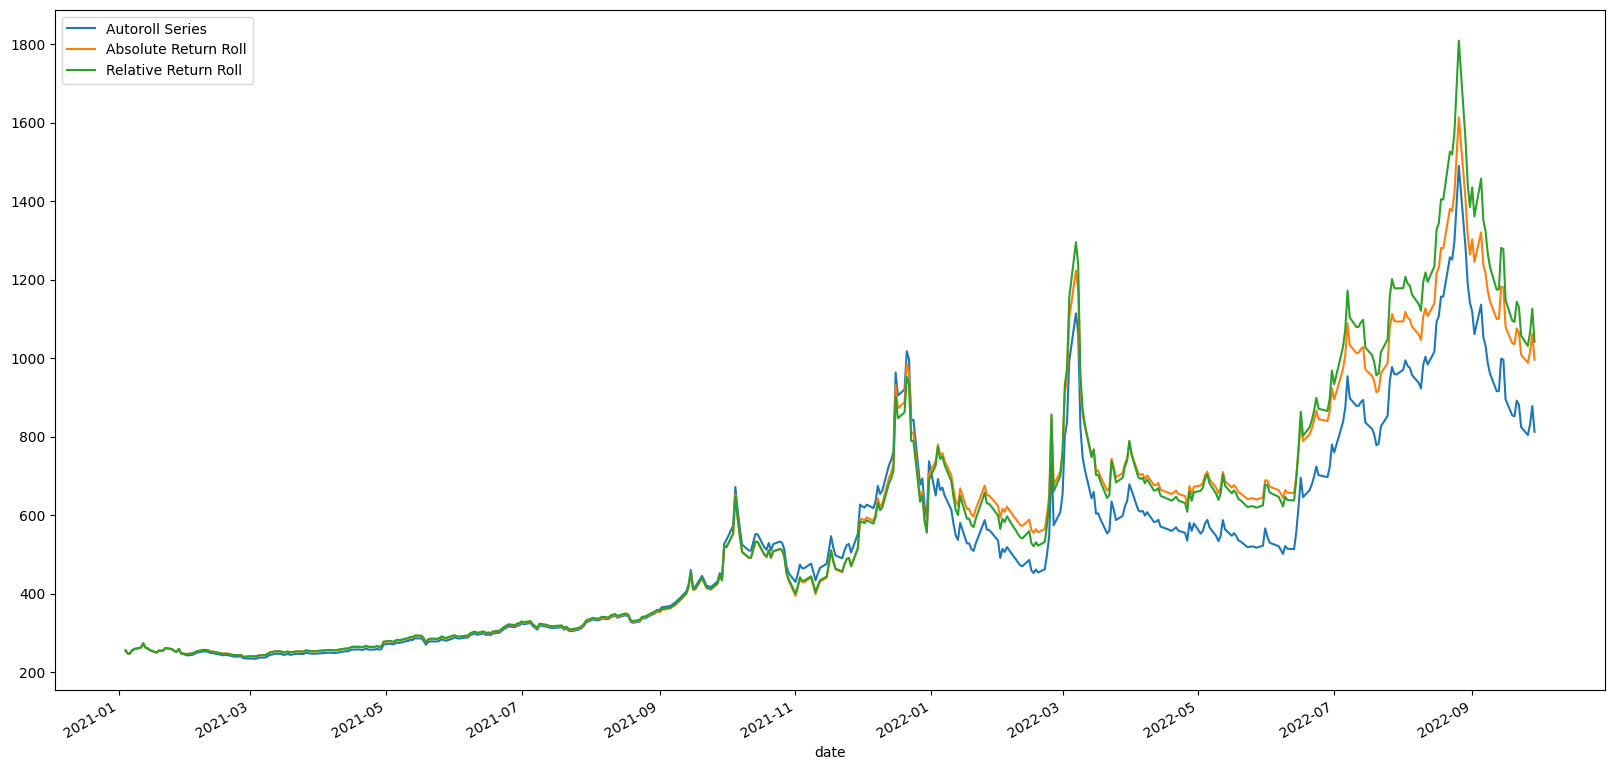

In [70]:
# Make a copy of the first contract
continuous_contract_absolute_method = continuous_contract.copy()
continuous_contract_relative_method = continuous_contract.copy()
# Apply the roll gaps
continuous_contract_absolute_method["close"] -= roll_gaps_absolute
continuous_contract_relative_method["close"] /= roll_gaps_relative
# Plot
fig = plt.figure(figsize=(20, 10))
_ = continuous_contract.close.plot(label="Autoroll Series")
_ = continuous_contract_absolute_method.close.plot(label="Absolute Return Roll")
_ = continuous_contract_relative_method.close.plot(label="Relative Return Roll")
_ = plt.legend(loc="best")
plt.show() 

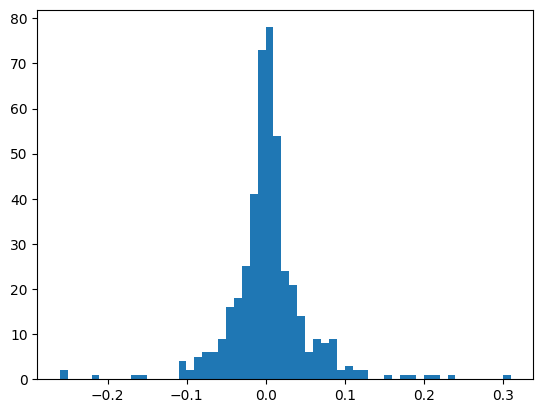

In [71]:
time_bars = np.log(continuous_contract_relative_method.close/continuous_contract_relative_method.close.shift(1)).dropna()

bin_len = 0.01
plt.hist(time_bars, bins=np.arange(min(time_bars),max(time_bars)+bin_len, bin_len))
plt.show()

In [72]:
# Transform the dataframe to keep index, close, volume and add value column
continuous_contract_relative_method = continuous_contract_relative_method[['close', 'volume']].copy().dropna()
continuous_contract_relative_method['value'] = continuous_contract_relative_method['close'] * continuous_contract_relative_method['volume']

In [73]:
def bar(x, y):
    return np.int64(x/y)*y

In [74]:


tick_bars = continuous_contract_relative_method.groupby(pd.Grouper(freq=f'W')).agg({'close': 'ohlc', 'volume': 'sum'})
tick_bars_price = tick_bars.loc[:, 'close']
tick_bars_price

,open,high,low,close
date,,,,
2021-01-10,255.440000,258.760000,247.380000,258.760000
2021-01-17,262.600000,273.300000,255.780000,255.780000
2021-01-24,249.920000,261.300000,249.920000,261.300000
2021-01-31,258.500000,259.160000,247.700000,247.700000
2021-02-07,245.893008,253.100672,245.893008,253.100672
...,...,...,...,...
2022-09-04,1556.533434,1556.533434,1360.985276,1360.985276
2022-09-11,1457.454662,1457.454662,1232.222628,1232.222628
2022-09-18,1174.433336,1280.752295,1147.834359,1147.834359


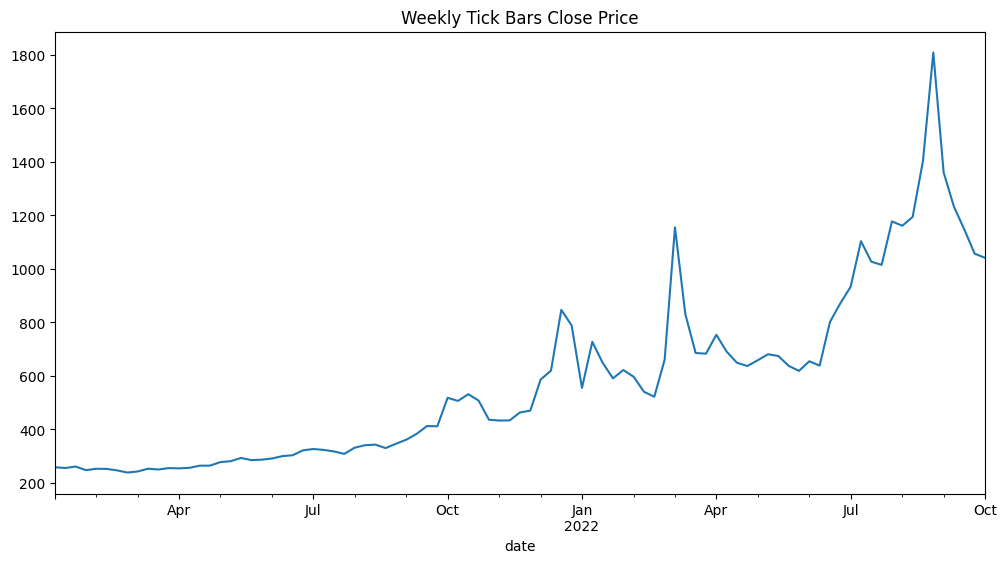

In [75]:
# Alternative: Plot using the full tick bars DataFrame
plt.figure(figsize=(12, 6))
tick_bars_price.close.plot(title='Weekly Tick Bars Close Price')
plt.show()

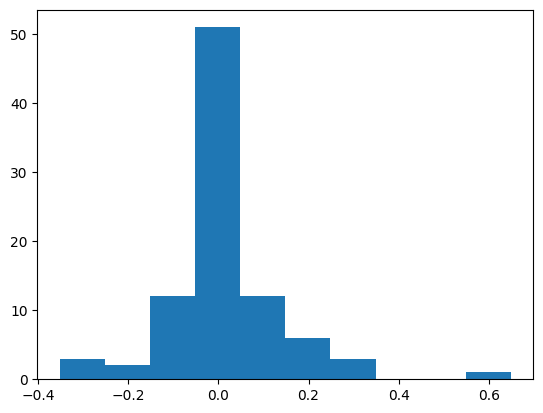

In [76]:
tick_bars = np.log(tick_bars_price.close/tick_bars_price.close.shift(1)).dropna()

bin_len = 0.1
plt.hist(tick_bars, bins=np.arange(min(tick_bars),max(tick_bars)+bin_len, bin_len))
plt.show()

In [77]:
# Using groupby similar to your existing code
weekly_volume = continuous_contract_relative_method.groupby(pd.Grouper(freq='W')).agg({
    'volume': ['sum', 'mean', 'count']
})

print("Weekly Volume Analysis:")
print(weekly_volume)

Weekly Volume Analysis:
             volume              
                sum    mean count
date                             
2021-01-10  12774.0  2554.8     5
2021-01-17  20018.0  4003.6     5
2021-01-24  20300.0  4060.0     5
2021-01-31  22936.0  4587.2     5
2021-02-07  21466.0  4293.2     5
...             ...     ...   ...
2022-09-04   9742.0  1948.4     5
2022-09-11   8142.0  1628.4     5
2022-09-18   8952.0  1790.4     5
2022-09-25  12514.0  2502.8     5
2022-10-02   9880.0  2470.0     4

[91 rows x 3 columns]


In [78]:
# Get the average of the weekly volume sums
avg_weekly_volume_sum = weekly_volume['volume']['sum'].mean()

print(f"Average Weekly Volume: {avg_weekly_volume_sum:,.0f}")

# Or assign it to the variable you're using later
overall_avg_weekly_volume = weekly_volume['volume']['sum'].mean()
print(f"Overall Average Weekly Volume: {overall_avg_weekly_volume:,.0f}")

Average Weekly Volume: 13,722
Overall Average Weekly Volume: 13,722


In [79]:
traded_volume = 13722

volume_bars = continuous_contract_relative_method.groupby(bar(np.cumsum(continuous_contract_relative_method['volume']), traded_volume)).agg({'close': 'ohlc', 'volume': 'sum'})
volume_bars_price = volume_bars.loc[:,'close']
volume_bars_price

,open,high,low,close
0,255.440000,258.760000,247.380000,258.760000
13722,262.600000,273.300000,262.600000,262.660000
27444,260.300000,260.300000,249.920000,254.820000
41166,254.260000,261.300000,254.260000,261.300000
54888,258.500000,258.500000,252.140000,252.140000
...,...,...,...,...
1180092,1327.205793,1526.252666,1327.205793,1519.040647
1193814,1572.972952,1809.075520,1385.096210,1435.036623
1207536,1360.985276,1457.454662,1174.433336,1175.356734
1221258,1280.752295,1280.752295,1092.558760,1143.653421


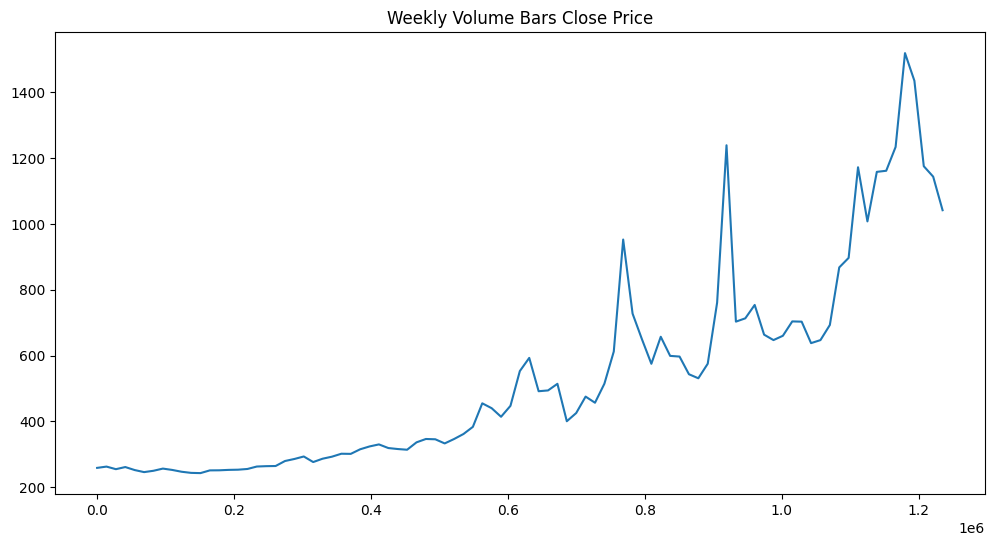

In [80]:
# Alternative: Plot using the full volume bars DataFrame
plt.figure(figsize=(12, 6))
volume_bars_price.close.plot(title='Weekly Volume Bars Close Price')
plt.show()

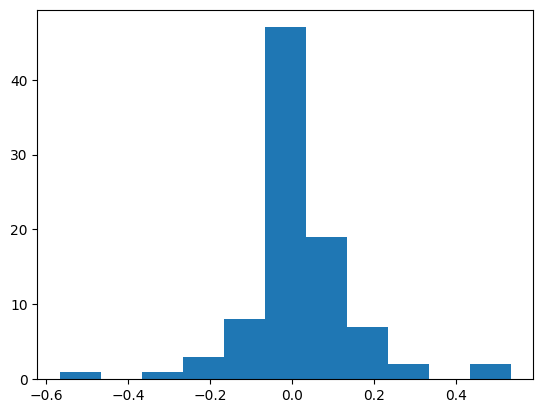

In [81]:
volume_bars = np.log(volume_bars_price.close/volume_bars_price.close.shift(1)).dropna()

bin_len = 0.1
plt.hist(volume_bars, bins=np.arange(min(volume_bars),max(volume_bars)+bin_len, bin_len))
plt.show()

In [82]:
# Using groupby similar to your existing code
weekly_value = continuous_contract_relative_method.groupby(pd.Grouper(freq='W')).agg({
    'value': ['sum', 'mean', 'count']
})

print("Weekly Value Analysis:")
print(weekly_value)

Weekly Value Analysis:
                   value                    
                     sum          mean count
date                                        
2021-01-10  3.221743e+06  6.443487e+05     5
2021-01-17  5.273608e+06  1.054722e+06     5
2021-01-24  5.180253e+06  1.036051e+06     5
2021-01-31  5.842923e+06  1.168585e+06     5
2021-02-07  5.336160e+06  1.067232e+06     5
...                  ...           ...   ...
2022-09-04  1.403598e+07  2.807195e+06     5
2022-09-11  1.080776e+07  2.161551e+06     5
2022-09-18  1.090197e+07  2.180394e+06     5
2022-09-25  1.383103e+07  2.766205e+06     5
2022-10-02  1.056699e+07  2.641747e+06     4

[91 rows x 3 columns]


In [83]:
# Get the average of the weekly value sums
avg_weekly_value_sum = weekly_value['value']['sum'].mean()

print(f"Average Weekly Value: {avg_weekly_value_sum:,.0f}")

# Or assign it to the variable you're using later
overall_avg_weekly_value = weekly_value['value']['sum'].mean()
print(f"Overall Average Weekly Value: {overall_avg_weekly_value:,.0f}")

Average Weekly Value: 7,287,227
Overall Average Weekly Value: 7,287,227


In [84]:
market_value = 7287227

dollar_bars = continuous_contract_relative_method.groupby(bar(np.cumsum(continuous_contract_relative_method['value']), market_value)).agg({'close': 'ohlc', 'volume':'sum'})
dollar_bars_price = dollar_bars.loc[:,'close']
dollar_bars_price

,open,high,low,close
0,255.440000,273.300000,247.380000,262.660000
7287227,260.300000,261.300000,249.920000,261.300000
14574454,258.500000,259.160000,245.893008,247.436057
21861681,247.557877,256.613139,247.557877,255.801008
29148908,252.714910,252.714910,242.969336,243.314492
...,...,...,...,...
626701522,1232.222628,1280.752295,1174.433336,1280.752295
633988749,1277.725604,1277.725604,1095.482852,1095.482852
641275976,1092.558760,1143.653421,1092.558760,1143.653421
648563203,1130.161558,1130.161558,1031.127179,1031.127179


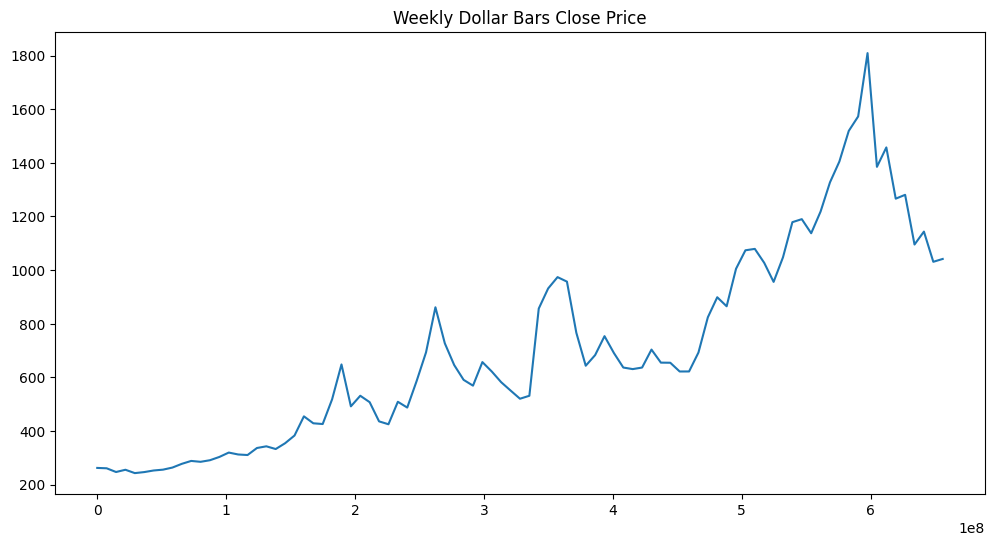

In [85]:
# Alternative: Plot using the full dollar bars DataFrame
plt.figure(figsize=(12, 6))
dollar_bars_price.close.plot(title='Weekly Dollar Bars Close Price')
plt.show()

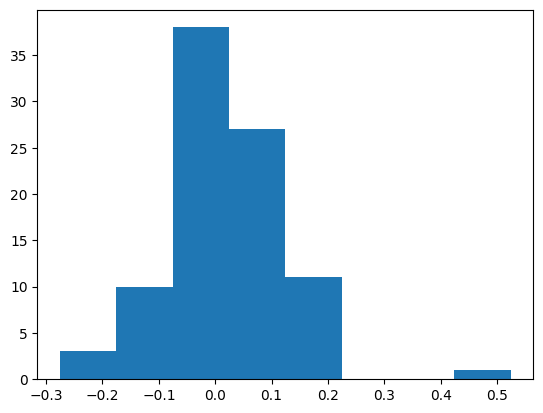

In [86]:
dollar_bars = np.log(dollar_bars_price.close/dollar_bars_price.close.shift(1)).dropna()

bin_len = 0.1
plt.hist(dollar_bars, bins=np.arange(min(dollar_bars),max(dollar_bars)+bin_len, bin_len))
plt.show()

Serial Correlation (Lag-1) of Tick Bars Returns: -0.0467
Serial Correlation (Lag-1): -0.0467
Serial Correlation (Lag-2): -0.2243
Serial Correlation (Lag-3): 0.0172
Serial Correlation (Lag-4): -0.0219
Serial Correlation (Lag-5): -0.0433


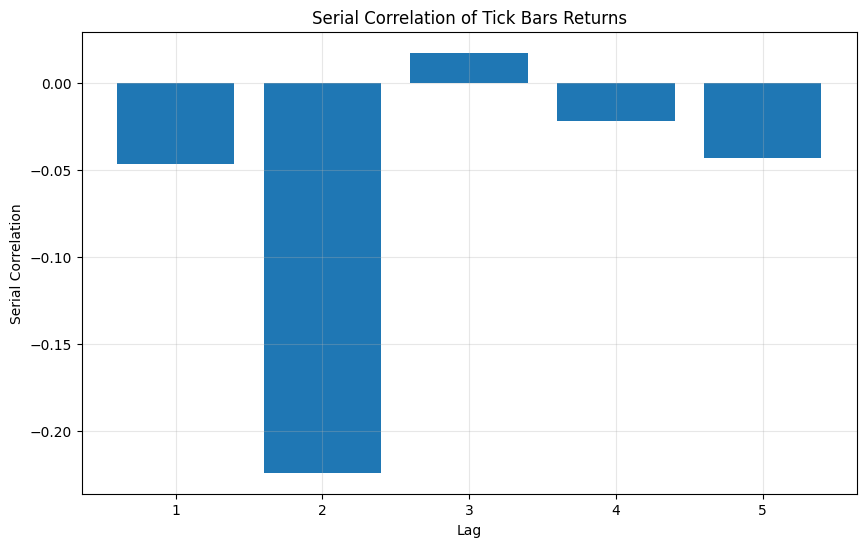

In [87]:
# Calculate serial correlation (lag-1 autocorrelation) of tick_bars returns
serial_correlation = tick_bars.corr(tick_bars.shift(1))

print(f"Serial Correlation (Lag-1) of Tick Bars Returns: {serial_correlation:.4f}")

# You can also calculate multiple lags
lags = [1, 2, 3, 4, 5]
serial_correlations = {}

for lag in lags:
    corr = tick_bars.corr(tick_bars.shift(lag))
    serial_correlations[f'Lag-{lag}'] = corr
    print(f"Serial Correlation (Lag-{lag}): {corr:.4f}")

# Plot the autocorrelation function
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(lags)+1), [serial_correlations[f'Lag-{lag}'] for lag in lags])
plt.xlabel('Lag')
plt.ylabel('Serial Correlation')
plt.title('Serial Correlation of Tick Bars Returns')
plt.grid(True, alpha=0.3)
plt.show()

Serial Correlation (Lag-1) of Volume Bars Returns: -0.1098
Serial Correlation (Lag-1): -0.1098
Serial Correlation (Lag-2): -0.1383
Serial Correlation (Lag-3): -0.0842
Serial Correlation (Lag-4): 0.0096
Serial Correlation (Lag-5): -0.0555


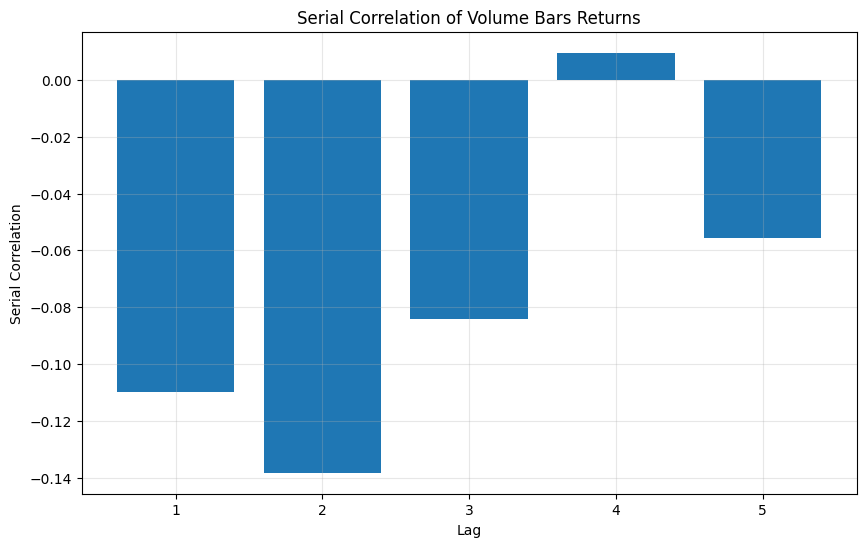

In [90]:
# Calculate serial correlation (lag-1 autocorrelation) of volume_bars returns
serial_correlation = volume_bars.corr(volume_bars.shift(1))

print(f"Serial Correlation (Lag-1) of Volume Bars Returns: {serial_correlation:.4f}")

# You can also calculate multiple lags
lags = [1, 2, 3, 4, 5]
serial_correlations = {}

for lag in lags:
    corr = volume_bars.corr(volume_bars.shift(lag))
    serial_correlations[f'Lag-{lag}'] = corr
    print(f"Serial Correlation (Lag-{lag}): {corr:.4f}")

# Plot the autocorrelation function
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(lags)+1), [serial_correlations[f'Lag-{lag}'] for lag in lags])
plt.xlabel('Lag')
plt.ylabel('Serial Correlation')
plt.title('Serial Correlation of Volume Bars Returns')
plt.grid(True, alpha=0.3)
plt.show()

Serial Correlation (Lag-1) of Dollar Bars Returns: 0.0607
Serial Correlation (Lag-1): 0.0607
Serial Correlation (Lag-2): -0.0436
Serial Correlation (Lag-3): -0.1346
Serial Correlation (Lag-4): -0.0446
Serial Correlation (Lag-5): -0.2270


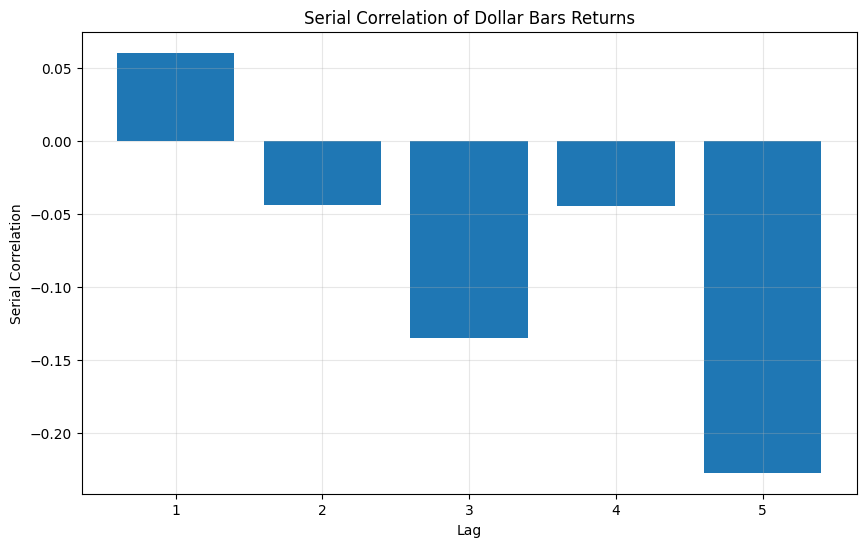

In [89]:
# Calculate serial correlation (lag-1 autocorrelation) of dollar_bars returns
serial_correlation = dollar_bars.corr(dollar_bars.shift(1))

print(f"Serial Correlation (Lag-1) of Dollar Bars Returns: {serial_correlation:.4f}")

# You can also calculate multiple lags
lags = [1, 2, 3, 4, 5]
serial_correlations = {}

for lag in lags:
    corr = dollar_bars.corr(dollar_bars.shift(lag))
    serial_correlations[f'Lag-{lag}'] = corr
    print(f"Serial Correlation (Lag-{lag}): {corr:.4f}")

# Plot the autocorrelation function
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(lags)+1), [serial_correlations[f'Lag-{lag}'] for lag in lags])
plt.xlabel('Lag')
plt.ylabel('Serial Correlation')
plt.title('Serial Correlation of Dollar Bars Returns')
plt.grid(True, alpha=0.3)
plt.show()

In [91]:
from scipy import stats

# Jarque-Bera normality test for tick_bars
jb_stat, jb_pvalue = stats.jarque_bera(tick_bars)

print(f"Jarque-Bera Test Results for Tick Bars:")
print(f"Test Statistic: {jb_stat:.4f}")
print(f"P-value: {jb_pvalue:.4f}")
print(f"Alpha (significance level): 0.05")

if jb_pvalue < 0.05:
    print("Result: Reject null hypothesis - Data is NOT normally distributed")
else:
    print("Result: Fail to reject null hypothesis - Data appears normally distributed")

# Additional statistics
print(f"\nDescriptive Statistics:")
print(f"Skewness: {stats.skew(tick_bars):.4f}")
print(f"Kurtosis: {stats.kurtosis(tick_bars):.4f}")
print(f"Mean: {tick_bars.mean():.4f}")
print(f"Standard Deviation: {tick_bars.std():.4f}")

Jarque-Bera Test Results for Tick Bars:
Test Statistic: 91.8105
P-value: 0.0000
Alpha (significance level): 0.05
Result: Reject null hypothesis - Data is NOT normally distributed

Descriptive Statistics:
Skewness: 0.7411
Kurtosis: 4.7208
Mean: 0.0155
Standard Deviation: 0.1232


In [92]:
# Run Jarque-Bera test on all bar types
bar_types = {
    'Tick Bars': tick_bars,
    'Volume Bars': volume_bars, 
    'Dollar Bars': dollar_bars
}

print("Jarque-Bera Normality Test Results:")
print("="*50)

for name, data in bar_types.items():
    jb_stat, jb_pvalue = stats.jarque_bera(data)
    print(f"\n{name}:")
    print(f"  JB Statistic: {jb_stat:.4f}")
    print(f"  P-value: {jb_pvalue:.4f}")
    print(f"  Normal: {'No' if jb_pvalue < 0.05 else 'Yes'}")
    print(f"  Skewness: {stats.skew(data):.4f}")
    print(f"  Kurtosis: {stats.kurtosis(data):.4f}")

Jarque-Bera Normality Test Results:

Tick Bars:
  JB Statistic: 91.8105
  P-value: 0.0000
  Normal: No
  Skewness: 0.7411
  Kurtosis: 4.7208

Volume Bars:
  JB Statistic: 122.5846
  P-value: 0.0000
  Normal: No
  Skewness: -0.1052
  Kurtosis: 5.7136

Dollar Bars:
  JB Statistic: 27.6523
  P-value: 0.0000
  Normal: No
  Skewness: 0.4402
  Kurtosis: 2.5688
